# Finding argmin for int Functions by  Grover's Algorithm and Amplitude Amplification

Grover's algorithm is one of the most famous quantum algorithms introduced by Lov Grover in 1996 \[1\]. It has initially been proposed for unstructured search problems, i.e. for finding a marked element in a unstructured database. However, Grover's algorithm is now a subroutine to several other algorithms, such as Grover Adaptive Search \[2\]. For the details of Grover's algorithm, please see [Grover's Algorithm](https://qiskit.org/textbook/ch-algorithms/grover.html) in the Qiskit textbook.

Qiskit implements Grover's algorithm in the `Grover` class. This class also includes the generalized version, Amplitude Amplification \[3\], and allows setting individual iterations and other meta-settings to Grover's algorithm.

**References:**

\[1\]: L. K. Grover, A fast quantum mechanical algorithm for database search. Proceedings 28th Annual Symposium on
the Theory of Computing (STOC) 1996, pp. 212-219. https://arxiv.org/abs/quant-ph/9605043

\[2\]: A. Gilliam, S. Woerner, C. Gonciulea, Grover Adaptive Search for Constrained Polynomial Binary Optimization.
https://arxiv.org/abs/1912.04088


\[3\]: Brassard, G., Hoyer, P., Mosca, M., & Tapp, A. (2000). Quantum Amplitude Amplification and Estimation. http://arxiv.org/abs/quant-ph/0005055

## Grover's algorithm

Grover's algorithm uses the Grover operator $\mathcal{Q}$ to amplify the amplitudes of the good states:

$$
    \mathcal{Q} = \mathcal{A}\mathcal{S_0}\mathcal{A}^\dagger \mathcal{S_f}
$$

Here, 
* $\mathcal{A}$ is the initial search state for the algorithm, which is just Hadamards, $H^{\otimes n}$ for the textbook Grover search, but can be more elaborate for Amplitude Amplification
* $\mathcal{S_0}$ is the reflection about the all 0 state
$$
    |x\rangle \mapsto \begin{cases} -|x\rangle, &x \neq 0 \\ |x\rangle, &x = 0\end{cases}
$$
* $\mathcal{S_f}$ is the oracle that applies 
$$
    |x\rangle \mapsto (-1)^{f(x)}|x\rangle
$$ 
&nbsp;&nbsp;&nbsp;&nbsp;　where $f(x)$ is 1 if $x$ is a good state and otherwise 0.

In a nutshell, Grover's algorithm applies different powers of $\mathcal{Q}$ and after each execution checks whether a good solution has been found. 

Example oracle circuit:

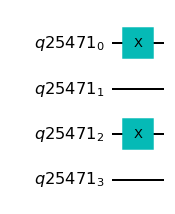

In [648]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import IntegerComparator
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit import execute, Aer

N = 4

def oracle_fun_N_bit():
    qr = QuantumRegister(N)
    qc = QuantumCircuit(qr, name='oracle')
    for idx in [0, 2]:#[0, 1, 3, 5, 7]:
        qc.x(qr[idx])
    return qc

f = oracle_fun_N_bit()
f.draw()

To uncompute you should just apply oracle again

Random arg func value sampling:

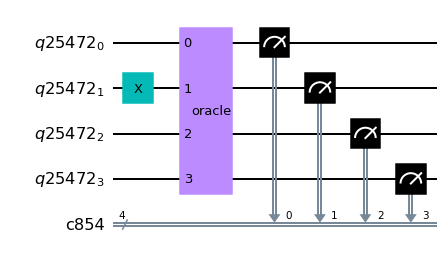

In [649]:
# Compute some random value out of oracle
import numpy as np
idxs = list(set(np.random.choice(range(N), N // 2)))

# Init circuit
qr = QuantumRegister(N)
cr = ClassicalRegister(N)
qc = QuantumCircuit(qr, cr)

#  Put random value on it
for idx in idxs:
    qc.x(qr[idx])
    
# Put oracle on the circuit
qc.append(f, range(N))
qc.measure(qr, cr)
qc.draw()

In [650]:
backend_sim = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend_sim)
result_sim = job_sim.result()
result_sim.get_counts()

{'0111': 1024}

In [651]:
counts = result_sim.get_counts()

input_ = np.zeros(N, dtype=np.int8)
input_[idxs] = 1
input_ = input_[::-1]

input_, counts

(array([0, 0, 1, 0], dtype=int8), {'0111': 1024})

Decoded values:

In [652]:
input_ = np.zeros(8, dtype=np.int8)
input_[idxs] = 1
input_ = input_[::-1]

input_ = int(''.join(map(str, input_)), 2)
output = int(list(counts.keys())[0], 2)

print(f'input: {input_}, output: {output}')

input: 2, output: 7


### Bit flip oracle

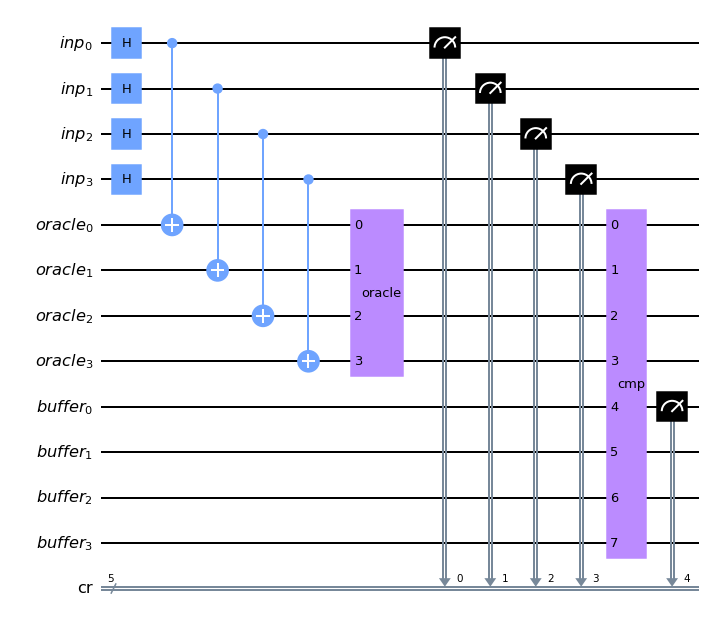

In [653]:
inp = QuantumRegister(N, name='inp')
f_oracle = QuantumRegister(N, name='oracle')
buffer = QuantumRegister(N, name='buffer')

c = ClassicalRegister(N + 1, name='cr')
qc = QuantumCircuit(inp, f_oracle, buffer, c)

val_to_cmp = 2**N - 6
# Init input
for i in range(N):
    qc.h(inp[i])
    # Entagle states
    qc.cx(inp[i], f_oracle[i])
    
    
qc.append(oracle_fun_N_bit(), range(N,2*N))
qc.append(IntegerComparator(N, val_to_cmp),range(N, 3*N))

qc.measure(inp, c[:N])
qc.measure(buffer[0],c[N])

qc.draw()

Let's sample reference states by simply sampling solutions by flip qubit oracle

In [654]:
backend_sim = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend_sim)
result_sim = job_sim.result()
#result_sim.get_counts()

In [655]:
good_state = ['0'*N + x[1:] for x in result_sim.get_counts() if x[0] == '1']

good_state

['00001111', '00001010', '00001000', '00001011', '00001110', '00001001']

### Bit Flip Oracle to Phase Flip Oracle

Code to make Phase Oracle out of Qbit Flip Oracle

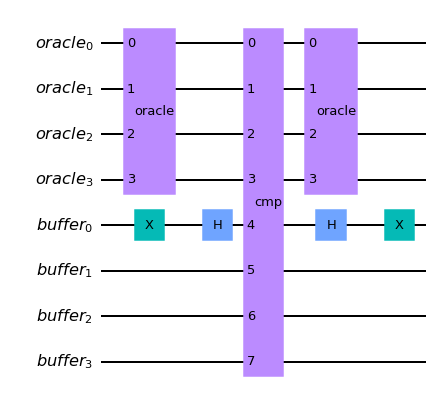

In [656]:
from qiskit.circuit.library import ZGate

def phase_flip_cmp(oracle_circuit):
    f_oracle = QuantumRegister(N, name='oracle')
    buffer = QuantumRegister(N, name='buffer')


    qc = QuantumCircuit(f_oracle, buffer)

    # Put result qbit in |-> state
    qc.x(buffer[0])
    qc.h(buffer[0])

    qc.append(oracle_circuit, range(N))
    qc.append(IntegerComparator(N, val_to_cmp),range(2*N))
    #qc.append(ZGate().control(2), [0, 1, 2])
    # Uncompute result qubit
    qc.h(buffer[0])
    qc.x(buffer[0])

    # uncompute oracle
    qc.append(oracle_circuit, range(N))
    return qc

oracle = phase_flip_cmp(oracle_fun_N_bit())
oracle.draw()

Let's define amplification problem

In [690]:
from qiskit import QuantumCircuit
from qiskit.algorithms import AmplificationProblem

# define Grover's algorithm
problem = AmplificationProblem(oracle, is_good_state=good_state)

# now we can have a look at the Grover operator that is used in running the algorithm
#problem.grover_operator.oracle.draw(output='mpl')

In [691]:
from qiskit.circuit.library import GroverOperator

grover_op = GroverOperator(oracle,reflection_qubits=list(range(N+1)), insert_barriers=True)
problem.grover_operator = grover_op

### Groover Algo Illustrations

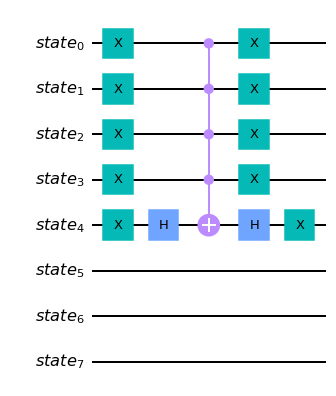

In [692]:
grover_op.zero_reflection.draw(output='mpl')

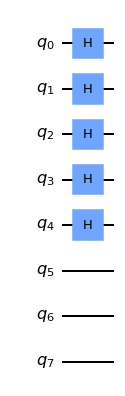

In [693]:
grover_op.state_preparation.draw(output='mpl')

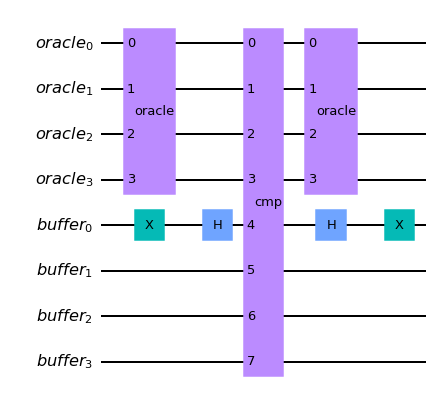

In [694]:
problem.grover_operator.oracle.draw()

### Results

Launch Apmlification problem and measure results

In [695]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover

aer_simulator = Aer.get_backend('aer_simulator')
grover = Grover(quantum_instance=aer_simulator, iterations=list(range(2*N)))
result = grover.amplify(problem)

print(f'Eval: {result.oracle_evaluation}')
print('Top measurement:', result.top_measurement)

Eval: True
Top measurement: 00001011


In [ ]:
Last N qbits should be zero, otherwise CMP circuit work unexpectedly. Filter only valid solutions 

In [696]:
res = {k: v for k, v in sorted(result.circuit_results[-1].items(), key=lambda item: -item[1]) if k[:N] == '0' * N}
res

{'00001011': 29,
 '00001010': 28,
 '00001000': 25,
 '00001111': 24,
 '00001110': 24,
 '00001001': 21,
 '00000111': 1,
 '00001101': 1,
 '00001100': 1,
 '00000000': 1}

In [697]:
for num in good_state:
    print(f'num: {num}, rank: {res[num]}')

num: 00001111, rank: 24
num: 00001010, rank: 28
num: 00001000, rank: 25
num: 00001011, rank: 29
num: 00001110, rank: 24
num: 00001001, rank: 21


In [669]:
print(result)

{   'assignment': '00001011',
    'circuit_results': [   {   '00000000': 3,
                               '00000001': 3,
                               '00000010': 7,
                               '00000011': 8,
                               '00000100': 6,
                               '00000101': 5,
                               '00000110': 6,
                               '00000111': 3,
                               '00001000': 5,
                               '00001001': 8,
                               '00001010': 4,
                               '00001011': 4,
                               '00001100': 4,
                               '00001101': 2,
                               '00001110': 5,
                               '00001111': 2,
                               '00010000': 2,
                               '00010001': 4,
                               '00010010': 4,
                               '00010011': 7,
                               '00010100': 5,
    

### tmp

In [16]:
def put_const_8bit(circuit, const, shift):
    print(const, '->', np.unpackbits(np.uint8(const)))
    for idx, bit in enumerate(np.unpackbits(np.uint8(const))):
        if bit:
            circuit.x(shift + idx)
            
def sum_8bit(circuit):
    shift = 8
    
    for digit in range(8):
        target_qbit = 3 * shift - 1 - digit
        carry_idx = 4*shift-1 -digit
        circuit.cx(shift - 1 - digit, target_qbit)
        circuit.cx(2*shift - 1 - digit, target_qbit)
        #carry
        # Add value from the previous carry register
        if digit:
            circuit.cx(carry_idx + 1, target_qbit)
        # Write A & B value to register
        circuit.ccx(shift -1 - digit,2*shift - 1 - digit, carry_idx)
        OR(2)
        circuit.append(OR(2),[)
        
        

0 -> [0 0 0 0 0 0 0 0]
0 -> [0 0 0 0 0 0 0 0]


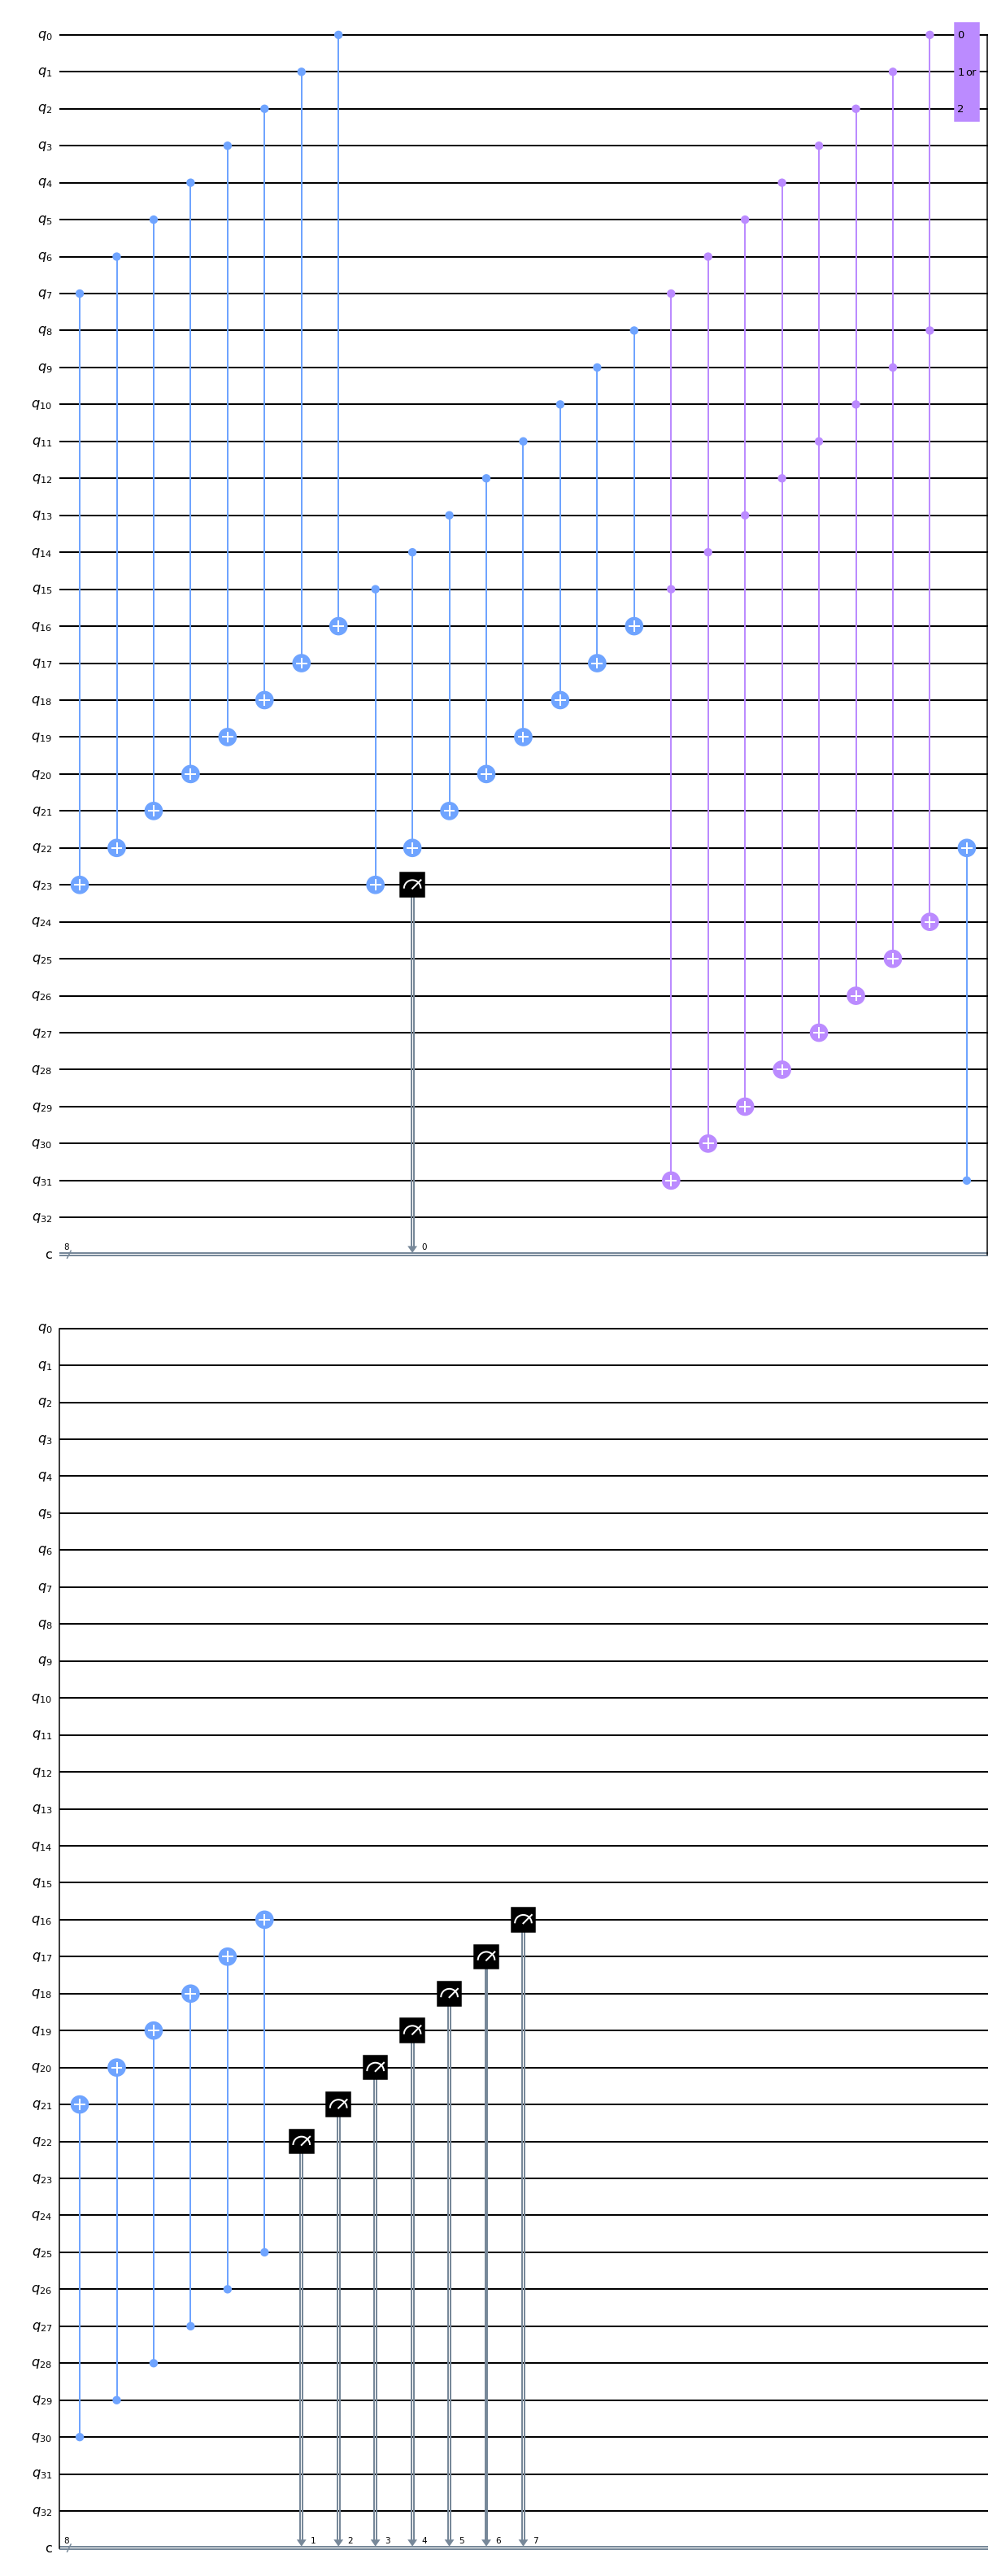

In [29]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit.circuit.library import IntegerComparator
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.circuit.library.boolean_logic.quantum_or import OR
import numpy as np

qbits_n = 8
bits_n = 8
oracle = QuantumCircuit(qbits_n, bits_n)
#for i in range(qbits_n):
#    oracle.h(i)
oracle.x(0)

cmp = QuantumCircuit(4*qbits_n+1, bits_n)

# Specify constant on qbits q8-q15
# for example let it be 10
# signet int8!
put_const_8bit(cmp, 0, 8)
        
# specify value from func output, ex 3
put_const_8bit(cmp, 0, 0)

sum_8bit(cmp)

shift = 23
for idx in range(8):
    cmp.measure(shift - idx, idx)


sim = Aer.get_backend('aer_simulator')
qobj = assemble(cmp)
counts = sim.run(qobj).result().get_counts()  # Do the simulation, returning the state vector
plot_histogram(counts)
or_ = OR(2)
#or_.draw()
cmp.append(or_, [0, 1, 2])
cmp.draw()

0

In [32]:
IntegerComparator

qiskit.circuit.library.arithmetic.integer_comparator.IntegerComparator

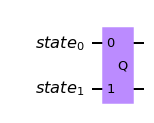

In [1]:
from qiskit import QuantumCircuit
from qiskit.algorithms import AmplificationProblem

# the state we desire to find is '11'
good_state = ['11']

# specify the oracle that marks the state '11' as a good solution
oracle = QuantumCircuit(2)
oracle.cz(0, 1)

# define Grover's algorithm
problem = AmplificationProblem(oracle, is_good_state=good_state)

# now we can have a look at the Grover operator that is used in running the algorithm
problem.grover_operator.draw(output='mpl')

Then, we specify a backend and call the `run` method of `Grover` with a backend to execute the circuits. The returned result type is a `GroverResult`. 

If the search was successful, the `oracle_evaluation` attribute of the result will be `True`. In this case, the most sampled measurement, `top_measurement`, is one of the "good states". Otherwise, `oracle_evaluation` will be False.


In [2]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover

aer_simulator = Aer.get_backend('aer_simulator')
grover = Grover(quantum_instance=aer_simulator)
result = grover.amplify(problem)
print('Result type:', type(result))
print()
print('Success!' if result.oracle_evaluation else 'Failure!')
print('Top measurement:', result.top_measurement)

Result type: <class 'qiskit.algorithms.amplitude_amplifiers.grover.GroverResult'>

Success!
Top measurement: 11


In the example, the result of `top_measurement` is `11` which is one of "good state". Thus, we succeeded to find the answer by using `Grover`.

In [3]:
from qiskit.quantum_info import Statevector
oracle = Statevector.from_label('11')
problem = AmplificationProblem(oracle, is_good_state=['11'])

grover = Grover(quantum_instance=aer_simulator)
result = grover.amplify(problem)
print('Result type:', type(result))
print()
print('Success!' if result.oracle_evaluation else 'Failure!')
print('Top measurement:', result.top_measurement)

Result type: <class 'qiskit.algorithms.amplitude_amplifiers.grover.GroverResult'>

Success!
Top measurement: 11


Internally, the statevector is mapped to a quantum circuit:

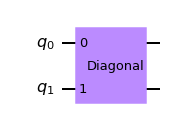

In [4]:
problem.grover_operator.oracle.draw(output='mpl')

Qiskit allows for an easy construction of more complex oracles:
* `PhaseOracle`: for parsing logical expressions such as `'~a | b'`. This is especially useful for solving 3-SAT problems and is shown in the accompanying [Grover Examples](07_grover_examples.ipynb) tutorial.

Here we'll use the `PhaseOracle` for the simple example of finding the state $|11\rangle$, which corresponds to `'a & b'`.

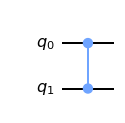

In [5]:
from qiskit.circuit.library.phase_oracle import PhaseOracle
from qiskit.exceptions import MissingOptionalLibraryError

# `Oracle` (`PhaseOracle`) as the `oracle` argument
expression = '(a & b)'
try:
    oracle = PhaseOracle(expression)
    problem = AmplificationProblem(oracle)
    display(problem.grover_operator.oracle.draw(output='mpl'))
except MissingOptionalLibraryError as ex:
    print(ex)

You can observe, that this oracle is actually implemented with three qubits instead of two!

That is because the `PhaseOracle` is not a phase-flip oracle (which flips the phase of the good state) but a bit-flip oracle. This means it flips the state of an auxiliary qubit if the other qubits satisfy the condition.
For Grover's algorithm, however, we require a phase-flip oracle. To convert the bit-flip oracle to a phase-flip oracle we sandwich the controlled-NOT by $X$ and $H$ gates, as you can see in the circuit above.

**Note:** This transformation from a bit-flip to a phase-flip oracle holds generally and you can use this to convert your oracle to the right representation.

state preparation circuit:


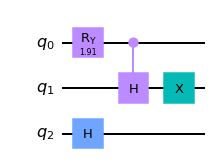

In [6]:
import numpy as np

# Specifying `state_preparation` 
# to prepare a superposition of |01>, |10>, and |11>
oracle = QuantumCircuit(3)
oracle.h(2)
oracle.ccx(0,1,2)
oracle.h(2)

theta = 2 * np.arccos(1 / np.sqrt(3))
state_preparation = QuantumCircuit(3)
state_preparation.ry(theta, 0)
state_preparation.ch(0,1)
state_preparation.x(1)
state_preparation.h(2)

# we only care about the first two bits being in state 1, thus add both possibilities for the last qubit
problem = AmplificationProblem(oracle, state_preparation=state_preparation, is_good_state=['110', '111'])

# state_preparation
print('state preparation circuit:')
problem.grover_operator.state_preparation.draw(output='mpl')

In [7]:
grover = Grover(quantum_instance=aer_simulator)
result = grover.amplify(problem)
print('Success!' if result.oracle_evaluation else 'Failure!')
print('Top measurement:', result.top_measurement)

Success!
Top measurement: 111


For instance, imagine the good state is a three qubit state $|111\rangle$ but we used 2 additional qubits as auxiliary qubits. 

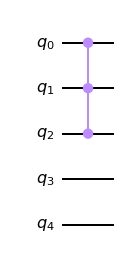

In [8]:
from qiskit.circuit.library import GroverOperator, ZGate

oracle = QuantumCircuit(5)
oracle.append(ZGate().control(2), [0, 1, 2])
oracle.draw(output='mpl')

Then, per default, the Grover operator implements the zero reflection on all five qubits.

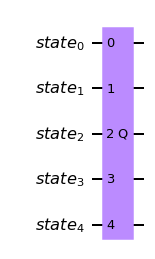

In [9]:
grover_op = GroverOperator(oracle, insert_barriers=True)
grover_op.draw(output='mpl')

But we know that we only need to consider the first three:

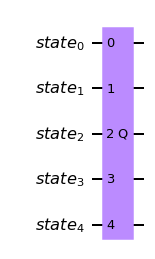

In [10]:
grover_op = GroverOperator(oracle, reflection_qubits=[0, 1, 2], insert_barriers=True)
grover_op.draw(output='mpl')

In [11]:
# a list of binary strings good state
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
good_state = ['11', '00']
problem = AmplificationProblem(oracle, is_good_state=good_state)
print(problem.is_good_state('11'))

True


In [12]:
# a list of integer good state
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
good_state = [0, 1]
problem = AmplificationProblem(oracle, is_good_state=good_state)
print(problem.is_good_state('11'))

True


In [13]:
from qiskit.quantum_info import Statevector

# `Statevector` good state
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
good_state = Statevector.from_label('11')
problem = AmplificationProblem(oracle, is_good_state=good_state)
print(problem.is_good_state('11'))

True


In [14]:
# Callable good state
def callable_good_state(bitstr):
    if bitstr == "11":
        return True
    return False

oracle = QuantumCircuit(2)
oracle.cz(0, 1)
problem = AmplificationProblem(oracle, is_good_state=good_state)
print(problem.is_good_state('11'))

True


In [15]:
# integer iteration
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
problem = AmplificationProblem(oracle, is_good_state=['11'])
grover = Grover(iterations=1)

In [16]:
# list iteration
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
problem = AmplificationProblem(oracle, is_good_state=['11'])
grover = Grover(iterations=[1, 2, 3])

In [17]:
# using sample_from_iterations
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
problem = AmplificationProblem(oracle, is_good_state=['11'])
grover = Grover(iterations=[1, 2, 3], sample_from_iterations=True)

When the number of solutions is known, we can also use a static method `optimal_num_iterations` to find the optimal number of iterations. Note that the output iterations is an approximate value. When the number of qubits is small, the output iterations may not be optimal.


In [18]:
iterations = Grover.optimal_num_iterations(num_solutions=1, num_qubits=8)
iterations

12

In [20]:
def to_DIAMACS_CNF_format(bit_rep):
    return [index+1 if val==1 else -1 * (index + 1) for index, val in enumerate(bit_rep)]

oracle = QuantumCircuit(2)
oracle.cz(0, 1)
problem = AmplificationProblem(oracle, is_good_state=['11'], post_processing=to_DIAMACS_CNF_format)
problem.post_processing([1, 0, 1])

[1, -2, 3]

In [21]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


Qiskit Software,Version
qiskit-terra,0.18.3
qiskit-aer,0.9.1
qiskit-ignis,0.6.0
qiskit-ibmq-provider,0.18.1
qiskit-aqua,0.9.5
qiskit,0.32.1
qiskit-nature,0.2.2
qiskit-finance,0.2.1
qiskit-optimization,0.2.3
qiskit-machine-learning,0.2.1
